*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containng both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*



---



For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

You can tweak epochs and batch size if you like, but it is not required.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Get project files
# uncomment at first run. comment next two lines, such that it does not 
# download data everytime you re-run this file/cell
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
#batch_size = 128
batch_size = 100
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
print(train_dir)
print(validation_dir)
print(test_dir)
!ls $train_dir/cats | wc -l
!ls $train_dir/dogs | wc -l
!ls $validation_dir/cats | wc -l
!ls $validation_dir/dogs | wc -l
!ls $test_dir
!ls $test_dir | wc -l

cats_and_dogs/train
cats_and_dogs/validation
cats_and_dogs/test
1000
1000
500
500
10.jpg	16.jpg	21.jpg	27.jpg	32.jpg	38.jpg	43.jpg	49.jpg	8.jpg
11.jpg	17.jpg	22.jpg	28.jpg	33.jpg	39.jpg	44.jpg	4.jpg	9.jpg
12.jpg	18.jpg	23.jpg	29.jpg	34.jpg	3.jpg	45.jpg	50.jpg	unlabeled
13.jpg	19.jpg	24.jpg	2.jpg	35.jpg	40.jpg	46.jpg	5.jpg
14.jpg	1.jpg	25.jpg	30.jpg	36.jpg	41.jpg	47.jpg	6.jpg
15.jpg	20.jpg	26.jpg	31.jpg	37.jpg	42.jpg	48.jpg	7.jpg
51


Now it is your turn! Set each of the variables below correctly. (They should no longer equal `None`.)

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


After you run the code, the output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [4]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir, 
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary' )
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir, 
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary' )
# make sure test data is in subdirectory
!mkdir -p $test_dir/unlabeled
!cp $test_dir/*.jpg $test_dir/unlabeled
test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir, 
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    class_mode='binary' )
!ls $test_dir/unlabeled

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
10.jpg	15.jpg	1.jpg	24.jpg	29.jpg	33.jpg	38.jpg	42.jpg	47.jpg	5.jpg
11.jpg	16.jpg	20.jpg	25.jpg	2.jpg	34.jpg	39.jpg	43.jpg	48.jpg	6.jpg
12.jpg	17.jpg	21.jpg	26.jpg	30.jpg	35.jpg	3.jpg	44.jpg	49.jpg	7.jpg
13.jpg	18.jpg	22.jpg	27.jpg	31.jpg	36.jpg	40.jpg	45.jpg	4.jpg	8.jpg
14.jpg	19.jpg	23.jpg	28.jpg	32.jpg	37.jpg	41.jpg	46.jpg	50.jpg	9.jpg


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the `train_data_gen` variable correctly, then running the cell below will plot five random training images.

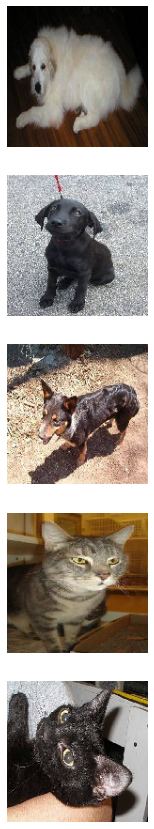

In [5]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.


In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.5,
    width_shift_range=0.1,
    height_shift_range=0.1)


You don't have to do anything for the next cell. `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


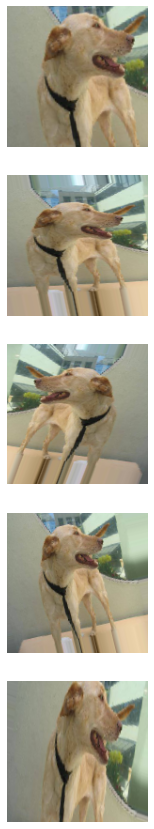

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)



In the cell below, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [8]:
model = Sequential()
model.add(Conv2D(10, (3,3), strides=(2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu")) 
model.add(MaxPooling2D())
model.add(Conv2D(20, (3,3), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(40, (3,3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(80, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 20)        1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 40)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 40)          0

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [9]:
history = model.fit(x=train_data_gen, epochs=epochs, validation_data=val_data_gen, steps_per_epoch=20, validation_steps=10)

Epoch 1/15
20/20 [==============================] - 26s 1s/step - loss: 0.6962 - accuracy: 0.5080 - val_loss: 0.6895 - val_accuracy: 0.5060
Epoch 2/15
20/20 [==============================] - 25s 1s/step - loss: 0.6905 - accuracy: 0.5090 - val_loss: 0.6838 - val_accuracy: 0.5140
Epoch 3/15
20/20 [==============================] - 25s 1s/step - loss: 0.6826 - accuracy: 0.5560 - val_loss: 0.6785 - val_accuracy: 0.5250
Epoch 4/15
20/20 [==============================] - 25s 1s/step - loss: 0.6732 - accuracy: 0.5905 - val_loss: 0.6550 - val_accuracy: 0.6160
Epoch 5/15
20/20 [==============================] - 26s 1s/step - loss: 0.6556 - accuracy: 0.6285 - val_loss: 0.6475 - val_accuracy: 0.6220
Epoch 6/15
20/20 [==============================] - 25s 1s/step - loss: 0.6374 - accuracy: 0.6525 - val_loss: 0.6312 - val_accuracy: 0.6520
Epoch 7/15
20/20 [==============================] - 25s 1s/step - loss: 0.6444 - accuracy: 0.6395 - val_loss: 0.6379 - val_accuracy: 0.6330
Epoch 8/15
20/20 [==

Run the next cell to visualize the accuracy and loss of the model.

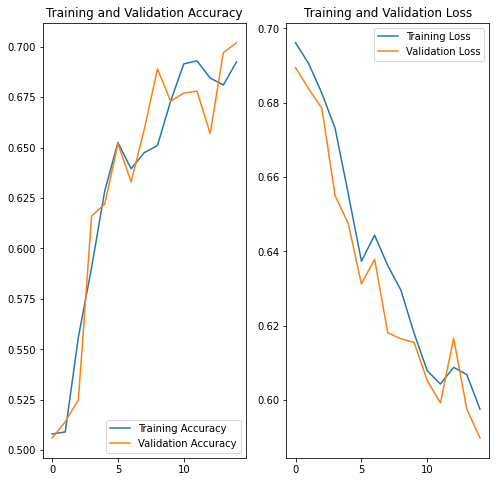

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

[[4.3570098e-01 5.6429905e-01]
 [9.1318738e-01 8.6812563e-02]
 [9.7662908e-01 2.3370912e-02]
 [1.8031275e-01 8.1968725e-01]
 [8.2049787e-01 1.7950208e-01]
 [6.7746866e-01 3.2253128e-01]
 [4.3207470e-02 9.5679259e-01]
 [8.4263921e-01 1.5736081e-01]
 [3.6115471e-02 9.6388453e-01]
 [3.8590055e-02 9.6140999e-01]
 [7.1212101e-01 2.8787902e-01]
 [1.7722771e-02 9.8227721e-01]
 [9.1809785e-01 8.1902087e-02]
 [9.9914408e-01 8.5595372e-04]
 [4.9363789e-01 5.0636214e-01]
 [4.6968195e-01 5.3031814e-01]
 [2.4409702e-01 7.5590301e-01]
 [2.0282217e-03 9.9797171e-01]
 [2.8441277e-01 7.1558732e-01]
 [4.0460691e-01 5.9539306e-01]
 [9.0874523e-01 9.1254771e-02]
 [4.5030221e-01 5.4969788e-01]
 [2.2427019e-01 7.7572984e-01]
 [8.9077121e-03 9.9109226e-01]
 [1.6049255e-02 9.8395073e-01]
 [9.5283371e-01 4.7166325e-02]
 [2.4400698e-01 7.5599301e-01]
 [3.7381127e-01 6.2618870e-01]
 [8.3915669e-01 1.6084336e-01]
 [6.1256307e-01 3.8743690e-01]
 [9.2984056e-01 7.0159435e-02]
 [9.0071487e-01 9.9285170e-02]
 [5.4578

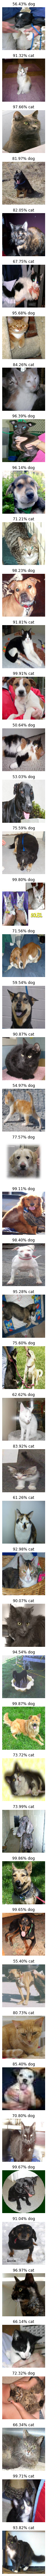

In [11]:
class_probabilities = model.predict(x=test_data_gen)
print(class_probabilities)
check_if_sums_are_one = [pair[0]+pair[1] for pair in class_probabilities]
print(check_if_sums_are_one)
#probabilities = [max(range(len(pair)), key=pair.__getitem__) for pair in class_probabilities]
probabilities = [pair[1] for pair in class_probabilities]
print(probabilities)
test_images, _ = next(test_data_gen)
plotImages(test_images[:50], probabilities)


Run this final cell to see if you passed the challenge or if you need to keep trying.

In [27]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {100*round(percentage_identified, 2):n}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78% of the images of cats and dogs.
You passed the challenge!
